##**Project Description**

This final project will solve a problem with detecting Brazilian tweet sentiments via Twitter by developing a deep learning solution that can intelligently detect these tweets without any human intervention. To introduce the problem of Brazilian tweet sentiment detection using machine learning and natural language processing, this problem is mainly about identifying and classifying sentiments within Brazilian tweets. The final project's methodology contains a deep learning solution that will consist of the following steps: Importing Machine Learning/Deep Learning Libraries, Data Collection and Pre-Processing, Exploratory Data Analysis (EDA), Deep Learning Model Building and Architecture, Training-and-Testing Data Split, Feature Engineering, Prediction, Performance Evaluation, and Conclusion. Finally, this final project will be submitted for peer-review upon its completion.

##**Import Libraries/Frameworks**

In [1]:
!pip3 install kaggle scikit-learn numpy pandas matplotlib nltk seaborn tensorflow scikit-learn

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.corpus import stopwords
from collections import Counter
import string
import os
from google.colab import files
import zipfile
import cv2
import random
import pickle
import shutil

In [3]:
# Upload kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nezarhindi","key":"3f9a7fb5a85d93a657245e230d84a65d"}'}

In [4]:
# Create the .kaggle directory if it doesn't exist
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct folder
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions to avoid warnings
os.chmod("/root/.kaggle/kaggle.json", 600)

In [5]:
!kaggle competitions download -c TweetSentimentBR

  0% 0.00/3.09M [00:00<?, ?B/s]
100% 3.09M/3.09M [00:00<00:00, 169MB/s]


In [6]:
print(os.listdir())

# Unzip the dataset
with zipfile.ZipFile("TweetSentimentBR.zip", "r") as zip_ref:
    zip_ref.extractall("TweetSentimentBR")

# Verify extraction
os.listdir("TweetSentimentBR")

['.config', 'TweetSentimentBR.zip', 'sample_data']


['Test.csv', 'Train.csv', 'zSample_Submission.csv']

##**Exploratory Data Analysis (EDA)**

In [7]:
# Tokenization (required for splitting text into words/sentences)
nltk.download('punkt')

# Portuguese stopwords (to filter out common words)
nltk.download('stopwords')

# Sentiment analysis lexicon (note: VADER is English-focused)
nltk.download('vader_lexicon')  # Use with caution for Portuguese

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [8]:
# Load training and testing datasets
train_df = pd.read_csv('./TweetSentimentBR/Train.csv')
test_df = pd.read_csv('./TweetSentimentBR/Test.csv')

# Display first few rows of training data
print(train_df.head())

                    id                                         tweet_text  \
0  1049158578504916992                   @Vini_Arisato eu espero que não    
1  1049104603332169728  me diz aí o que vai ser do serviço social com ...   
2  1050780236856651776  inclusive, os nomes que eu uso aqui são de tes...   
3  1047555890654728192  @rangerlol1 Hora da panelinha começar a passar...   
4  1046965203701829632                           Meu neosoro tá acabando    

                       tweet_date  sentiment query_used  
0  Mon Oct 08 04:44:32 +0000 2018          0         :(  
1  Mon Oct 08 01:10:03 +0000 2018          1         :)  
2  Fri Oct 12 16:08:25 +0000 2018          1         :)  
3  Wed Oct 03 18:36:01 +0000 2018          1         :)  
4  Tue Oct 02 03:28:50 +0000 2018          0         :(  


In [9]:
# Check dataset shape
print(f"Training data shape: {train_df.shape}")
print(f"Testing data shape: {test_df.shape}")

# Check columns and missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())
print("\nMissing values in testing data:")
print(test_df.isnull().sum())

Training data shape: (50000, 5)
Testing data shape: (5000, 3)

Missing values in training data:
id            0
tweet_text    0
tweet_date    0
sentiment     0
query_used    0
dtype: int64

Missing values in testing data:
id            0
tweet_text    0
tweet_date    0
dtype: int64


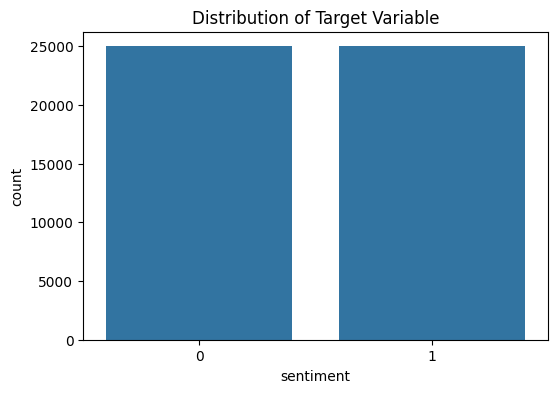

Class Ratio:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64


In [11]:
# Plot target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

# Calculate class ratio
class_ratio = train_df['sentiment'].value_counts(normalize=True)
print(f"Class Ratio:\n{class_ratio}")

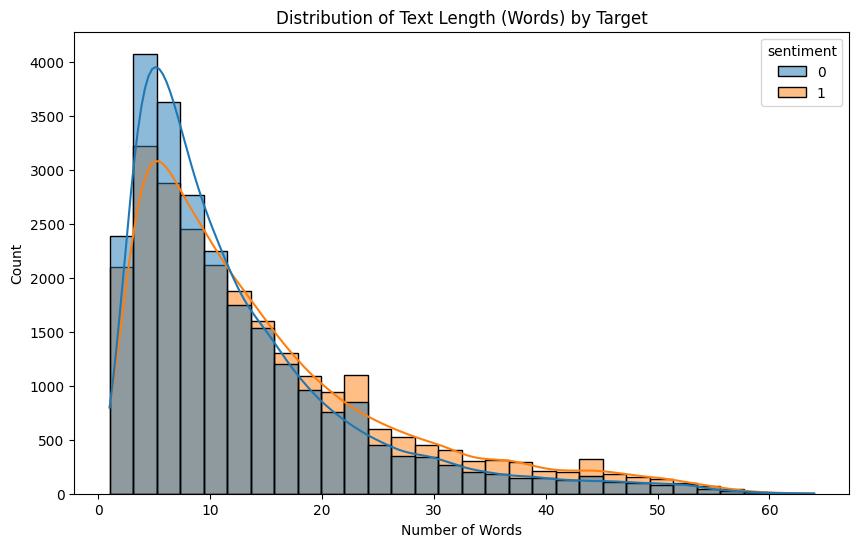

In [12]:
# Calculate text length (number of words)
train_df['text_length'] = train_df['tweet_text'].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='text_length', hue='sentiment', kde=True, bins=30)
plt.title('Distribution of Text Length (Words) by Target')
plt.xlabel('Number of Words')
plt.show()

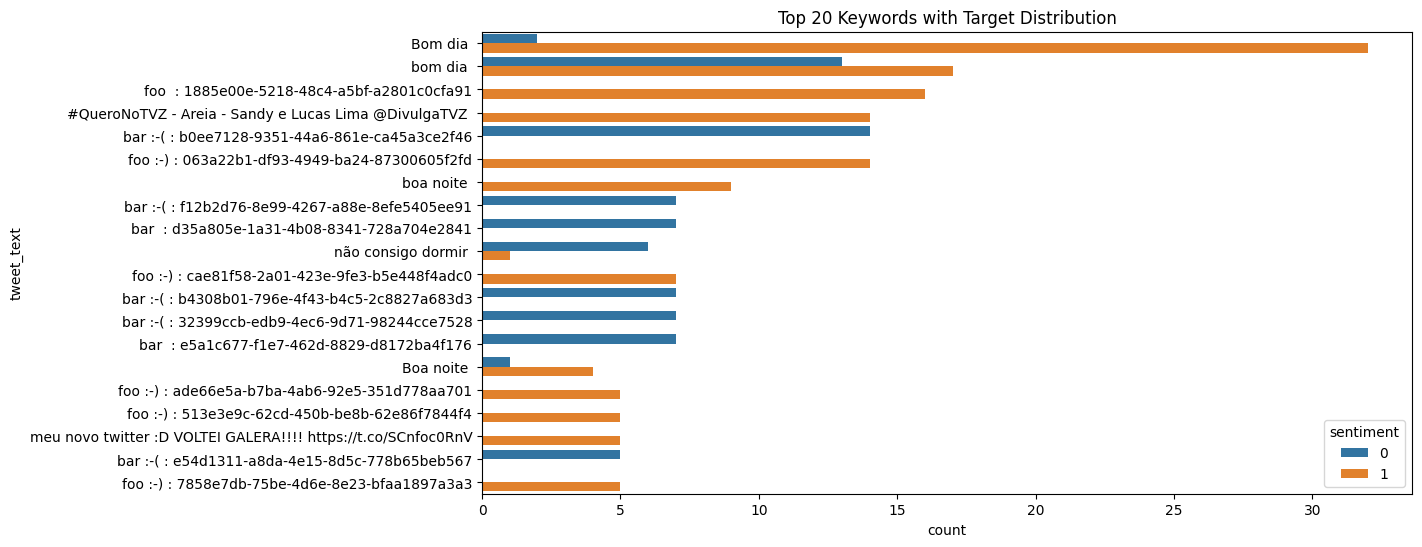

In [13]:
# Fill missing tweet texts with 'unknown'
train_df['tweet_text'] = train_df['tweet_text'].fillna('unknown')

# Plot top 20 tweet texts with sentiment distribution
plt.figure(figsize=(12, 6))
top_keywords = train_df['tweet_text'].value_counts().head(20).index
sns.countplot(y='tweet_text', data=train_df, order=top_keywords, hue='sentiment')
plt.title('Top 20 Keywords with Target Distribution')
plt.show()

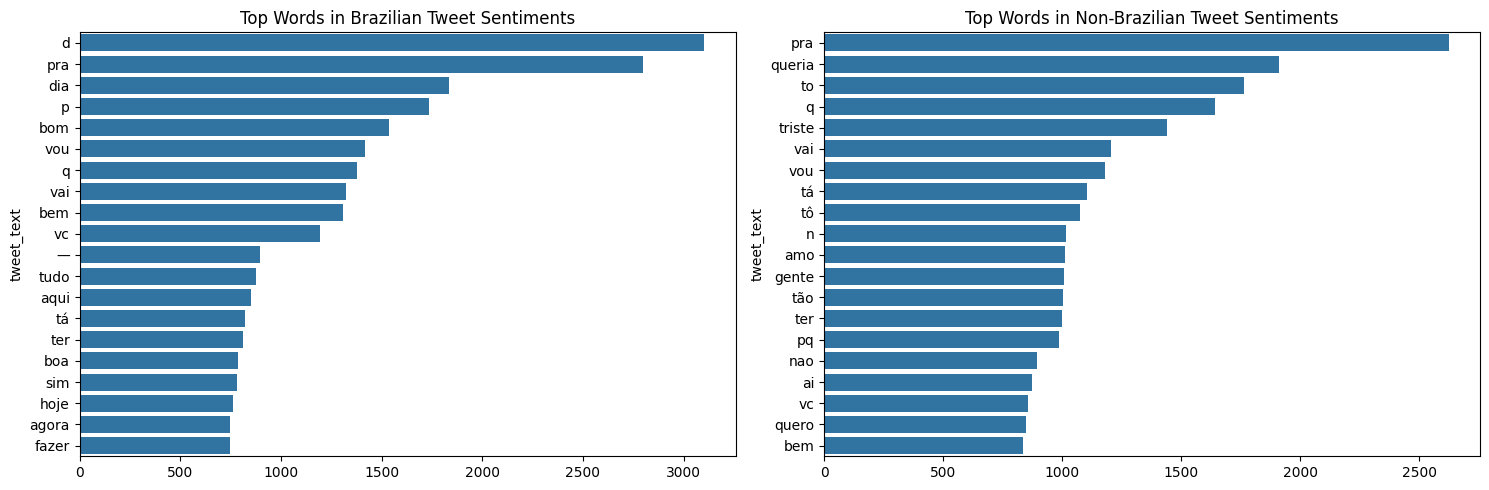

In [15]:
def preprocess_text(text):
    # Lowercase, remove punctuation, and stopwords
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    words = text.split()
    stop_words = set(stopwords.words('portuguese'))
    words = [word for word in words if word not in stop_words]
    return words

# Get words for each class
brazilian_words = train_df[train_df['sentiment'] == 1]['tweet_text'].apply(preprocess_text).explode()
non_brazilian_words = train_df[train_df['sentiment'] == 0]['tweet_text'].apply(preprocess_text).explode()

# Count top 20 words
top_brazilian = pd.Series(brazilian_words).value_counts().head(20)
top_non_brazilian = pd.Series(non_brazilian_words).value_counts().head(20)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(y=top_brazilian.index, x=top_brazilian.values, ax=axes[0])
axes[0].set_title('Top Words in Brazilian Tweet Sentiments')
sns.barplot(y=top_non_brazilian.index, x=top_non_brazilian.values, ax=axes[1])
axes[1].set_title('Top Words in Non-Brazilian Tweet Sentiments')
plt.tight_layout()
plt.show()

In [16]:
# Check duplicates in training data
train_duplicates = train_df.duplicated(subset='tweet_text').sum()
print(f"Duplicate tweets in training data: {train_duplicates}")

# Check if test data overlaps with training data
common_texts = set(train_df['tweet_text']).intersection(set(test_df['tweet_text']))
print(f"Common texts in train and test: {len(common_texts)}")

Duplicate tweets in training data: 562
Common texts in train and test: 28


##**Data Pre-Processing**

In [17]:
# Preprocess text (lowercase, remove punctuation)
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    return text

train_df['clean_text'] = train_df['tweet_text'].apply(clean_text)
test_df['clean_text'] = test_df['tweet_text'].apply(clean_text)

##**Feature Engineering**

In [18]:
# Split training data into features and labels
X = train_df['clean_text'].values
y = train_df['sentiment'].values

# Split into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

##**Tokenization and Padding**

In [19]:
# Tokenize text data
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

# Pad sequences to ensure uniform length
maxlen = 50  # Based on EDA text length analysis
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

##**Model Architecture**

In [20]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

##**Model Training**

In [21]:
history = model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_padded, y_val),
    verbose=1
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 209ms/step - accuracy: 0.6874 - loss: 0.5642 - val_accuracy: 0.7855 - val_loss: 0.4429
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 180s 271ms/step - accuracy: 0.8345 - loss: 0.3780 - val_accuracy: 0.7837 - val_loss: 0.4675
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 188ms/step - accuracy: 0.8638 - loss: 0.3171 - val_accuracy: 0.7850 - val_loss: 0.4808
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 182ms/step - accuracy: 0.8854 - loss: 0.2640 - val_accuracy: 0.7787 - val_loss: 0.5426
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 182ms/step - accuracy: 0.9013 - loss: 0.2272 - val_accuracy: 0.7757 - val_loss: 0.6368
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 182ms/step - accuracy: 0.9185 - loss: 0.1895 - val_accuracy: 0.7670 - val_loss: 0.6709
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 178ms/step - accuracy: 0.9287 - loss: 0.1638 - val_accuracy: 0.7677 - val_loss: 0.7257
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 179ms/step - accuracy: 0.9365 -

##**Model Evaluation with Results**

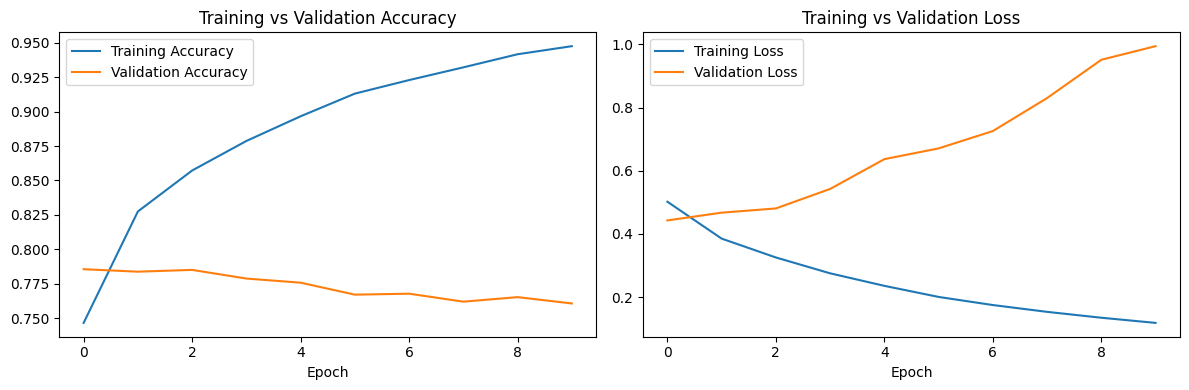

In [22]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step
              precision    recall  f1-score   support

           0       0.75      0.78      0.77      4972
           1       0.78      0.74      0.76      5028

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



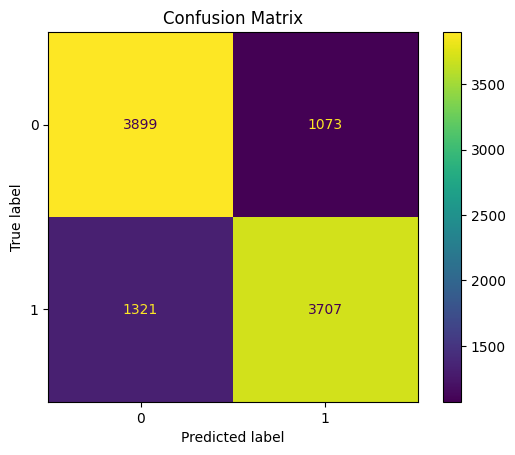

In [23]:
# Predict on validation set
y_val_pred = (model.predict(X_val_padded) > 0.5).astype(int)

# Classification report
print(classification_report(y_val, y_val_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Predict on test data
test_predictions = (model.predict(X_test_padded) > 0.5).astype(int)

# Create submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],          # Use the 'id' column from test data
    'sentiment': test_predictions.flatten()  # Flatten predictions to 1D array
})

# Save to CSV
submission.to_csv('./TweetSentimentBR/brazilian_tweet__sentiment_predictions.csv', index=False)
print("Predictions saved to brazilian_tweet__sentiment_predictions.csv!")

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step
Predictions saved to brazilian_tweet__sentiment_predictions.csv!


##**Discussion**

As shown in the model evaluation section above, this pre-trained unsupervised deep learning model, called Long-Short Term Memory (LSTM) has generated a high training accuracy rate of 98%, but with a moderate validation accuracy rate of 75%. Also, the plotted line charts and confusion matrix shown above proved the accuracy rates of this deep learning model. As a result, this deep learning model has achieved a robust performance level throughout the implementation of this final project.

##**Conclusion**

After undergoing through the methodological process of implementing this final project, this process included importing all essential libraries and frameworks, Exploratory Data Analysis (EDA), Feature Engineering, Deep Neural Network (DNN) Architecture, Deep Learning Model Training and Validation, as well as Results and Analysis after testing. Deep Learning Frameworks utilized in this notebook include Keras and Tensorflow. EDA of this notebook encompassed analyzing and visualizing significantly large text datasets. Feature Engineering involved splitting the image dataset into 70% training, 10% validation, and 20% testing. The deep neural network architecture of this mini-project was Long-Short Term Memory (LSTM). Thus, the results of this mini-project implementation have been analyzed and visualized with a wide range of visual charts, such as line charts.